# Twitter AI influencers analysis
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/other-industries/influencers-analysis/notebooks/main.ipynb)._]

### Introduction

In this notebook, we perform an analysis of the posts from the Twitter AI influencers in order to provide a list of the top influencers with regard to some specific KPIs.

Here are the KPIs that we use for our analysis:

- The mean number of replies per tweet
- The mean number of retweets and quotes per tweet
- The mean number of likes per tweet

First, we calculate these KPIs considering all the tweets, then we determine them for the most popular topics (topics with the most associated tweets, including all types: tweet, reply, quote and like).

In [1]:
import os
import random as rd
from pathlib import Path
from zipfile import ZipFile

import atoti as tt
import numpy as np
import pandas as pd
import wget
from IPython.display import clear_output, display

#### Global variables

In [2]:
RESULTS_PATH = Path("results")

### Data download  

Skip the following step if you already downloaded the data to your local.

In [3]:
def bar_custom(current, total, width=80):
    clear_output(wait=True)
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))


data_url = (
    "https://data.atoti.io/notebooks/influencers-analysis/influencers-analysis.zip"
)
wget.download(data_url, bar=bar_custom)

with ZipFile("influencers-analysis.zip", "r") as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()

Downloading: 100% [2537248 / 2537248] bytes


# STEP 0: Load the results

In [4]:
df = pd.read_csv(RESULTS_PATH / "Topic Extraction - all.csv")

print(f"Data size: {df.shape}\n")
df.head(2)

Data size: (8079, 30)



,tweetLink,text,retweet_count,favorite_count,reply_count,quote_count,topic,topic_count,profileUrl,name,...,topic_keyword_11,topic_keyword_12,topic_keyword_13,topic_keyword_14,topic_keyword_15,topic_keyword_16,topic_keyword_17,topic_keyword_18,topic_keyword_19,topic_keyword_20
0,https://twitter.com/YvesMulkers/status/1396799...,"RT @CREWcrew:Mitch McConnell got $250,000 from...",1010,0,0,0,186,153,https://twitter.com/YvesMulkers,Yves Mulkers,...,"('ai', 0.02533194981053806)","('leading tech', 0.024722970994140298)","('choose great', 0.024722970994140298)","('great wine', 0.024722970994140298)","('tech trends', 0.024722970994140298)","('intelligence movies', 0.024588839428707168)","('wine', 0.024252606974425835)","('leading', 0.024165918247990883)","('usa', 0.02414878068708062)","('movies', 0.024140236513879545)"
1,https://twitter.com/data_nerd/status/139693655...,Madrona Venture Group’s Steve Singh on key tre...,0,0,0,0,186,153,https://twitter.com/data_nerd,Carla Gentry,...,"('ai', 0.02533194981053806)","('leading tech', 0.024722970994140298)","('choose great', 0.024722970994140298)","('great wine', 0.024722970994140298)","('tech trends', 0.024722970994140298)","('intelligence movies', 0.024588839428707168)","('wine', 0.024252606974425835)","('leading', 0.024165918247990883)","('usa', 0.02414878068708062)","('movies', 0.024140236513879545)"


In [5]:
exemplars_df = pd.read_csv(RESULTS_PATH / "Topic Extraction - exemplars only.csv")

print(f"Data size: {exemplars_df.shape}\n")
exemplars_df.head(2)

Data size: (4038, 30)



,tweetLink,text,retweet_count,favorite_count,reply_count,quote_count,topic,topic_count,profileUrl,name,...,topic_keyword_11,topic_keyword_12,topic_keyword_13,topic_keyword_14,topic_keyword_15,topic_keyword_16,topic_keyword_17,topic_keyword_18,topic_keyword_19,topic_keyword_20
0,https://twitter.com/KayFButterfield/status/139...,RT @SethBergeson:📣STARTING NOW! #SmartToyAward...,2,0,0,0,186,153,https://twitter.com/KayFButterfield,KayFirth-Butterfield,...,"('ai', 0.02533194981053806)","('leading tech', 0.024722970994140298)","('choose great', 0.024722970994140298)","('great wine', 0.024722970994140298)","('tech trends', 0.024722970994140298)","('intelligence movies', 0.024588839428707168)","('wine', 0.024252606974425835)","('leading', 0.024165918247990883)","('usa', 0.02414878068708062)","('movies', 0.024140236513879545)"
1,https://twitter.com/pierrepinna/status/1395448...,RT @DeepLearn007:Leading Tech Trends 2021\r\n\...,126,0,0,0,186,153,https://twitter.com/pierrepinna,Pinna Pierre,...,"('ai', 0.02533194981053806)","('leading tech', 0.024722970994140298)","('choose great', 0.024722970994140298)","('great wine', 0.024722970994140298)","('tech trends', 0.024722970994140298)","('intelligence movies', 0.024588839428707168)","('wine', 0.024252606974425835)","('leading', 0.024165918247990883)","('usa', 0.02414878068708062)","('movies', 0.024140236513879545)"


From the above quick exploratory data analysis, we have noticed no irregularity in the data in term of:
- Missing data
- Infinite values
- redundant data

The data is clean so we can proceed our analysis.

# STEP 1: Prepare the data

In [6]:
topics_cols = [c for c in df.columns if "topic" in c or "keyword" in c]
topics_df = df[topics_cols].drop_duplicates(subset=["topic"])
topics_df = topics_df.reset_index(drop=True)

print(f"Data size: {topics_df.shape}\n")
topics_df.head()

Data size: (336, 22)



,topic,topic_count,topic_keyword_1,topic_keyword_2,topic_keyword_3,topic_keyword_4,topic_keyword_5,topic_keyword_6,topic_keyword_7,topic_keyword_8,...,topic_keyword_11,topic_keyword_12,topic_keyword_13,topic_keyword_14,topic_keyword_15,topic_keyword_16,topic_keyword_17,topic_keyword_18,topic_keyword_19,topic_keyword_20
0,186,153,"('2021', 0.11518344111464827)","('trends', 0.06973633657430857)","('trends 2021', 0.04791319519051584)","('2021 ai', 0.041789472437149734)","('companies', 0.03782389258944172)","('watch 2021', 0.03740412879855314)","('watch', 0.03687575794795414)","('iot', 0.031124820300891674)",...,"('ai', 0.02533194981053806)","('leading tech', 0.024722970994140298)","('choose great', 0.024722970994140298)","('great wine', 0.024722970994140298)","('tech trends', 0.024722970994140298)","('intelligence movies', 0.024588839428707168)","('wine', 0.024252606974425835)","('leading', 0.024165918247990883)","('usa', 0.02414878068708062)","('movies', 0.024140236513879545)"
1,96,136,"('security', 0.13334875147029324)","('cybersecurity', 0.06613946852875736)","('server', 0.04812775359226998)","('vulnerabilities', 0.04753864385244478)","('protect', 0.04664468941473375)","('security vulnerabilities', 0.03804328196636811)","('machinelearning security', 0.03804328196636811)","('report highlights', 0.03804328196636811)",...,"('growing threat', 0.03804328196636811)","('web report', 0.03804328196636811)","('hackers', 0.03700637689061967)","('threat', 0.0366620556522023)","('highlights', 0.03660856377351593)","('cyber', 0.036009969037109894)","('web', 0.035272071778176234)","('report', 0.03361564675896366)","('growing', 0.03335609543508208)","('online', 0.03320985993021597)"
2,112,132,"('healthcare', 0.08062913143207898)","('ai', 0.05952155861485934)","('future', 0.058975517545946286)","('future ai', 0.049136348227743466)","('cancer', 0.04197501211933508)","('artificial intelligence', 0.037859947522765086)","('intelligence', 0.03716322363479036)","('artificial', 0.037041730134947215)",...,"('doctor', 0.03409881855831573)","('disease', 0.0335395197066635)","('healthtech', 0.0332097995751255)","('drugs combat', 0.024660267842207345)","('bone', 0.024660267842207345)","('current drugs', 0.024660267842207345)","('paulapicc', 0.024660267842207345)","('intelligence improve', 0.024660267842207345)","('teach big', 0.024660267842207345)","('healthcare enzc', 0.024660267842207345)"
3,22,129,"('spacex', 0.08589130794119605)","('space', 0.08050827064759014)","('earth', 0.0730039525475797)","('moon', 0.061162312916090415)","('mission', 0.06107994265280764)","('view earth', 0.04893123080850168)","('captured', 0.04893123080850168)","('view', 0.045779234310052146)",...,"('starlink', 0.034937815331619035)","('captured capsule', 0.034937815331619035)","('iss', 0.034937815331619035)","('space station', 0.034937815331619035)","('earth iss', 0.034937815331619035)","('clearest picture', 0.034937815331619035)","('clearest', 0.034937815331619035)","('space shuttle', 0.034937815331619035)","('station captured', 0.034937815331619035)","('international space', 0.034937815331619035)"
4,329,117,"('ama', 0.06914391674971687)","('05', 0.06495635291986186)","('average', 0.06380059646402073)","('called', 0.06354995794021061)","('rstats', 0.05819670264538107)","('today', 0.04850149381542877)","('great', 0.04480246824313703)","('continue south', 0.03879269368962269)",...,"('mlb adley', 0.03879269368962269)","('validation playing', 0.03879269368962269)","('ama reddit', 0.03879269368962269)","('session animated', 0.03879269368962269)","('ama today', 0.03879269368962269)","('called monte', 0.03879269368962269)","('called trolling', 0.03879269368962269)","('chose rstats', 0.03879269368962269)","('kombucha taproom', 0.03879269368962269)","('sections', 0.03879269368962269)"


In [7]:
cols = [c for c in df.columns if "keyword" not in c and "proba" not in c]
df = df[cols].drop_duplicates(subset=["tweetLink"])
df = df.reset_index(drop=True)

print(f"Data size: {df.shape}\n")
df.head()

Data size: (8079, 10)



,tweetLink,text,retweet_count,favorite_count,reply_count,quote_count,topic,topic_count,profileUrl,name
0,https://twitter.com/YvesMulkers/status/1396799...,"RT @CREWcrew:Mitch McConnell got $250,000 from...",1010,0,0,0,186,153,https://twitter.com/YvesMulkers,Yves Mulkers
1,https://twitter.com/data_nerd/status/139693655...,Madrona Venture Group’s Steve Singh on key tre...,0,0,0,0,186,153,https://twitter.com/data_nerd,Carla Gentry
2,https://twitter.com/TamaraMcCleary/status/1395...,2021 Internet Of Things 50: The Bright Lights ...,10,11,0,0,186,153,https://twitter.com/TamaraMcCleary,Tamara McCleary
3,https://twitter.com/data_nerd/status/139585064...,Top Companies 2021: The 50 best workplaces to ...,0,0,0,0,186,153,https://twitter.com/data_nerd,Carla Gentry
4,https://twitter.com/Ronald_vanLoon/status/1396...,Whoever Leads In #ArtificialIntelligence In 20...,7,5,0,1,186,153,https://twitter.com/Ronald_vanLoon,Ronald van Loon


# STEP 3: Atoti's magic!
In this part, we leverage the power of Atoti to post-process the results in order to produce some insights.

## Atoti cube creation  

We have a simple cube that holds a single data table. Let's call it influencer_table.

In [8]:
# a session has to be created for atoti
session = tt.Session()

In [9]:
influencer_table = session.read_pandas(
    df, table_name="influencer", default_values={"topic": 0}
)
influencer_table.head()

,tweetLink,text,retweet_count,favorite_count,reply_count,quote_count,topic,topic_count,profileUrl,name
0,https://twitter.com/YvesMulkers/status/1396799...,"RT @CREWcrew:Mitch McConnell got $250,000 from...",1010,0,0,0,186,153,https://twitter.com/YvesMulkers,Yves Mulkers
1,https://twitter.com/YvesMulkers/status/1391437...,RT @Paula_Piccard: Vivino: Choose Your Next Gr...,27,0,0,0,186,153,https://twitter.com/YvesMulkers,Yves Mulkers
2,https://twitter.com/Ronald_vanLoon/status/1391...,The World’s 20 Most Profitable Companies\r\nby...,16,14,0,0,186,153,https://twitter.com/Ronald_vanLoon,Ronald van Loon
3,https://twitter.com/clmt/status/13899514133635...,RT @JFPuget: Nvidia is on #TIME100Companies: a...,1,0,0,0,186,153,https://twitter.com/clmt,Clément Farabet
4,https://twitter.com/drfeifei/status/1392193417...,"RT @StanfordHAI: This week, an intensive AI co...",11,0,0,0,186,153,https://twitter.com/drfeifei,Fei-Fei Li


In [10]:
cube = session.create_cube(influencer_table, "influencer_cube", mode="no_measures")

h, m, l = cube.hierarchies, cube.measures, cube.levels

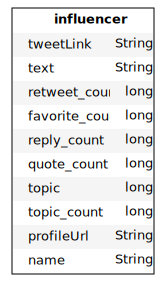

In [11]:
cube.schema

## Create measures
Here, we create the following measures for our analysis:

- The mean number of replies per tweet
- The mean number of retweets and quotes per tweet
- The mean number of likes per tweet

We also consider their overall mean over all the influencers.

In [12]:
m["replies"] = tt.agg.mean(influencer_table["reply_count"])
m["retweets_quotes"] = tt.agg.mean(
    influencer_table["retweet_count"] + influencer_table["quote_count"]
)
m["likes"] = tt.agg.mean(influencer_table["favorite_count"])

m["replies_mean"] = tt.total(m["replies"], h["name"])
m["retweets_quotes_mean"] = tt.total(m["retweets_quotes"], h["name"])
m["likes_mean"] = tt.total(m["likes"], h["name"])

We format de created measure

In [13]:
m["replies"].formatter = "DOUBLE[#,###.00]"
m["retweets_quotes"].formatter = "DOUBLE[#,###.00]"
m["likes"].formatter = "DOUBLE[#,###.00]"
m["replies_mean"].formatter = "DOUBLE[#,###.00]"
m["retweets_quotes_mean"].formatter = "DOUBLE[#,###.00]"
m["likes_mean"].formatter = "DOUBLE[#,###.00]"

## Create hierarchies

In [14]:
h["topic"] = [influencer_table["topic"]]

## Visualize insights
Here, we create the following visualizations to present our results:

#### Top 10 influencers - Number of replies, retweets and quotes, and likes per tweets

In [15]:
session.visualize(
    "Top 10 influencers - Number of replies, retweets and quotes, and likes per tweets"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

The table here above shows, for each influencer:

- The number of tweets from each influencer (in the last colonne (contributor.COUNT))
- The average number of replies for each tweet
- The average number of retweets and quotes for each tweet
- The average number of likes for each tweet

We can observe that, in general, it's not those who produce the most tweets that are the most replied to, retweeted or liked.
It's the case with Dr. Robin Kiera who tweeted the most last month (346 tweets), but is not even amongst the top 10 most replied.

The following visualization illustrate well our obersvation.

#### Top 10 influencers - Number of replies per tweet

In [16]:
session.visualize("Top 10 influencers - Number of replies per tweet")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Top 10 influencers - Number of retweets and quotes per tweet

In [17]:
session.visualize("Top 10 influencers - Number of retweets and quotes per tweet")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Top 10 influencers - Number of likes per tweet

In [18]:
session.visualize("Top 10 influencers - Number of likes per tweet")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

The graphs demonstrate well that there is a clear distinction between the qantity or the tweets produced by an influencer and the number of people he reaches in terms of the number of replies, retweets and quotes, and likes he gets from his posts.

In fact, if we consider the top 3 influencers that post the most: 
- Dr. Robin Kiera
- KDnuggets
- Tamara McCleary

We oserve that none of them is within the top 10 influencers whose tweets are the most replied, retweeted or quoted, or liked.

Unlike these influencers, if we consider Andrej Karpathy who has the higher replies and likes rates per tweet, we can observe that he is actually not even amongst the top 20 influencers with the most tweets.

As a consequence, it seems that being more replied, retweeted, quoted or liked has more to have with the content of the tweets written or their quality.

#### In what follows, we the perform the same kind of analysis than before, but for each topic
#### We will focus only on the 5 most discussed topics (top 5 topics with the most tweets associated)

#### Top 5 topics
Here, we consider the most popular topics as being the ones with the most related tweets, replies, retweets, quotes, and likes.

In [19]:
session.visualize("Top 5 topics")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Top 5 topics - Labels and illustrations
First, we will give a label to each of the considered top topics, and we also provide a sample of the tweets that illustrate them the best.

In [20]:
topics_df.head()

,topic,topic_count,topic_keyword_1,topic_keyword_2,topic_keyword_3,topic_keyword_4,topic_keyword_5,topic_keyword_6,topic_keyword_7,topic_keyword_8,...,topic_keyword_11,topic_keyword_12,topic_keyword_13,topic_keyword_14,topic_keyword_15,topic_keyword_16,topic_keyword_17,topic_keyword_18,topic_keyword_19,topic_keyword_20
0,186,153,"('2021', 0.11518344111464827)","('trends', 0.06973633657430857)","('trends 2021', 0.04791319519051584)","('2021 ai', 0.041789472437149734)","('companies', 0.03782389258944172)","('watch 2021', 0.03740412879855314)","('watch', 0.03687575794795414)","('iot', 0.031124820300891674)",...,"('ai', 0.02533194981053806)","('leading tech', 0.024722970994140298)","('choose great', 0.024722970994140298)","('great wine', 0.024722970994140298)","('tech trends', 0.024722970994140298)","('intelligence movies', 0.024588839428707168)","('wine', 0.024252606974425835)","('leading', 0.024165918247990883)","('usa', 0.02414878068708062)","('movies', 0.024140236513879545)"
1,96,136,"('security', 0.13334875147029324)","('cybersecurity', 0.06613946852875736)","('server', 0.04812775359226998)","('vulnerabilities', 0.04753864385244478)","('protect', 0.04664468941473375)","('security vulnerabilities', 0.03804328196636811)","('machinelearning security', 0.03804328196636811)","('report highlights', 0.03804328196636811)",...,"('growing threat', 0.03804328196636811)","('web report', 0.03804328196636811)","('hackers', 0.03700637689061967)","('threat', 0.0366620556522023)","('highlights', 0.03660856377351593)","('cyber', 0.036009969037109894)","('web', 0.035272071778176234)","('report', 0.03361564675896366)","('growing', 0.03335609543508208)","('online', 0.03320985993021597)"
2,112,132,"('healthcare', 0.08062913143207898)","('ai', 0.05952155861485934)","('future', 0.058975517545946286)","('future ai', 0.049136348227743466)","('cancer', 0.04197501211933508)","('artificial intelligence', 0.037859947522765086)","('intelligence', 0.03716322363479036)","('artificial', 0.037041730134947215)",...,"('doctor', 0.03409881855831573)","('disease', 0.0335395197066635)","('healthtech', 0.0332097995751255)","('drugs combat', 0.024660267842207345)","('bone', 0.024660267842207345)","('current drugs', 0.024660267842207345)","('paulapicc', 0.024660267842207345)","('intelligence improve', 0.024660267842207345)","('teach big', 0.024660267842207345)","('healthcare enzc', 0.024660267842207345)"
3,22,129,"('spacex', 0.08589130794119605)","('space', 0.08050827064759014)","('earth', 0.0730039525475797)","('moon', 0.061162312916090415)","('mission', 0.06107994265280764)","('view earth', 0.04893123080850168)","('captured', 0.04893123080850168)","('view', 0.045779234310052146)",...,"('starlink', 0.034937815331619035)","('captured capsule', 0.034937815331619035)","('iss', 0.034937815331619035)","('space station', 0.034937815331619035)","('earth iss', 0.034937815331619035)","('clearest picture', 0.034937815331619035)","('clearest', 0.034937815331619035)","('space shuttle', 0.034937815331619035)","('station captured', 0.034937815331619035)","('international space', 0.034937815331619035)"
4,329,117,"('ama', 0.06914391674971687)","('05', 0.06495635291986186)","('average', 0.06380059646402073)","('called', 0.06354995794021061)","('rstats', 0.05819670264538107)","('today', 0.04850149381542877)","('great', 0.04480246824313703)","('continue south', 0.03879269368962269)",...,"('mlb adley', 0.03879269368962269)","('validation playing', 0.03879269368962269)","('ama reddit', 0.03879269368962269)","('session animated', 0.03879269368962269)","('ama today', 0.03879269368962269)","('called monte', 0.03879269368962269)","('called trolling', 0.03879269368962269)","('chose rstats', 0.03879269368962269)","('kombucha taproom', 0.03879269368962269)","('sections', 0.03879269368962269)"


We provide the list of the top 10 keywords that define this topic, along side with their associated importance (the higher, the more important).

In [21]:
cols = [c for c in topics_cols if "keyword" in c]

#### Topic 186: Trends for 2021

In [22]:
topic = 186
topic_keywords = topics_df[topics_df["topic"] == topic][cols].values.flatten().tolist()

print(f"Topic {topic} keywords:\n")
for kw in topic_keywords[:10]:
    print(kw)

Topic 186 keywords:

('2021', 0.11518344111464827)
('trends', 0.06973633657430857)
('trends 2021', 0.04791319519051584)
('2021 ai', 0.041789472437149734)
('companies', 0.03782389258944172)
('watch 2021', 0.03740412879855314)
('watch', 0.03687575794795414)
('iot', 0.031124820300891674)
('10', 0.029940307679780117)
('fintech', 0.027130500269414805)


Then, we provide a sample of tweets that best illustrate this topic

In [23]:
exemplars = exemplars_df[exemplars_df["topic"] == topic]["text"].to_list()
sample = rd.sample(exemplars, 3)

print(f"Top {topic} representatives tweets:\n")

for idx, s in enumerate(sample):
    print("{}:{}\n".format(idx + 1, s))

Top 186 representatives tweets:

1:RT @marcusborba: Top 10 Must Watch Artificial Intelligence Movies

https://t.co/l3IdoMCyrj @analyticsinme 

#ArtificialIntelligence #DeepLe…

2:RT @TrendingNews_7: Choose Your Next Great #Wine

With #BigData And #ArtificialIntelligence

https://t.co/YmCSEz4xiM #fintech #AI #MachineL…

3:RT @SethBergeson:📣STARTING NOW! #SmartToyAwards 2021 https://t.co/HJ7So5IN0m @ProfKlausSchwab speaking now, then @iamwill, @unicefchief, and other judges announcing winners! Join us and learn about the future of #childhood &amp; #play. Thanks @iamangelfdn @unicef @Touchcast @wef @PwC #ResponsibleAI



#### Topic 96: Cybersecurity

We provide the list of keywords that define this topic, along side with their associated importance (the higher, the more important).

In [24]:
topic = 96
topic_keywords = topics_df[topics_df["topic"] == topic][cols].values.flatten().tolist()

print(f"Topic {topic} keywords:\n")
for kw in topic_keywords[:10]:
    print(kw)

Topic 96 keywords:

('security', 0.13334875147029324)
('cybersecurity', 0.06613946852875736)
('server', 0.04812775359226998)
('vulnerabilities', 0.04753864385244478)
('protect', 0.04664468941473375)
('security vulnerabilities', 0.03804328196636811)
('machinelearning security', 0.03804328196636811)
('report highlights', 0.03804328196636811)
('vulnerabilities growing', 0.03804328196636811)
('threat web', 0.03804328196636811)


Then, we provide a sample of tweets that best illustrate this topic

In [25]:
exemplars = exemplars_df[exemplars_df["topic"] == topic]["text"].to_list()
sample = rd.sample(exemplars, 3)

print(f"Top {topic} representatives tweets:\n")

for idx, s in enumerate(sample):
    print("{}:{}\n".format(idx + 1, s))

Top 96 representatives tweets:

1:#deeplearning based Computer Vision System for Automated Tyre Defect Detection
As the global manufacturing industry faces the pressures of bringing to market multiple variants of the highest qualit ..
https://t.co/4SlfaC9icX https://t.co/gvJYIgdS1X

2:Breakthrough Army technology is a game changer for deepfake detection https://t.co/OqETRn9eLH via @YouTube

3:#Cybersecurity: These two basic flaws make it easy for hackers to break into your systems 

https://t.co/kPhueoZ6jT v/ @ZDNet @dannyjpalmer

Cc @SpirosMargaris @Shirastweet @StephaneNappo @TopCyberNews @dabonneville @roxanasoi @AlaricAloor @pierrepinna @Ym78200



#### Topic 112: AI & Healthcare

We provide the list of keywords that define this topic, along side with their associated importance (the higher, the more important).

In [26]:
topic = 112
topic_keywords = topics_df[topics_df["topic"] == topic][cols].values.flatten().tolist()

print(f"Topic {topic} keywords:\n")
for kw in topic_keywords[:10]:
    print(kw)

Topic 112 keywords:

('healthcare', 0.08062913143207898)
('ai', 0.05952155861485934)
('future', 0.058975517545946286)
('future ai', 0.049136348227743466)
('cancer', 0.04197501211933508)
('artificial intelligence', 0.037859947522765086)
('intelligence', 0.03716322363479036)
('artificial', 0.037041730134947215)
('ai healthcare', 0.034528025288226544)
('diagnosis', 0.034512708842210735)


Then, we provide a sample of tweets that best illustrate this topic

In [27]:
exemplars = exemplars_df[exemplars_df["topic"] == topic]["text"].to_list()
sample = rd.sample(exemplars, 3)

print(f"Top {topic} representatives tweets:\n")

for idx, s in enumerate(sample):
    print("{}:{}\n".format(idx + 1, s))

Top 112 representatives tweets:

1:The Doctor Is In: Three Predictions For The Future Of #AI In #Healthcare https://t.co/Co8dDaMD1k via Forbes https://t.co/TyiojbMIhn

2:Top story: Google Strikes Deal With Hospital Chain to Develop Healthcare Algorithms - WSJ https://t.co/NZUgmFuafn, see more https://t.co/16gz3lCgEh

3:RT @andi_staub: Promoting the Responsible Use of #AI in #HealthCare

#insurtech #fintech #opendata #datascience #bigdata @terence_mills @Fa…



#### Topic 22: Space

We provide the list of keywords that define this topic, along side with their associated importance (the higher, the more important).

In [28]:
topic = 22
topic_keywords = topics_df[topics_df["topic"] == topic][cols].values.flatten().tolist()

print(f"Topic {topic} keywords:\n")
for kw in topic_keywords[:10]:
    print(kw)

Topic 22 keywords:

('spacex', 0.08589130794119605)
('space', 0.08050827064759014)
('earth', 0.0730039525475797)
('moon', 0.061162312916090415)
('mission', 0.06107994265280764)
('view earth', 0.04893123080850168)
('captured', 0.04893123080850168)
('view', 0.045779234310052146)
('amazing', 0.04149003287911507)
('picture sun', 0.034937815331619035)


Then, we provide a sample of tweets that best illustrate this topic

In [29]:
exemplars = exemplars_df[exemplars_df["topic"] == topic]["text"].to_list()
sample = rd.sample(exemplars, 3)

print(f"Top {topic} representatives tweets:\n")

for idx, s in enumerate(sample):
    print("{}:{}\n".format(idx + 1, s))

Top 22 representatives tweets:

1:Mercury Ascents Along With Crescent Moon as Brilliant Venus Returns This Week; How to Watch It https://t.co/rkmbV5CJpc

2:RT @alvinfoo:#SpaceX in 2029 🚀 https://t.co/QONLtJjn0s

3:RT @alvinfoo: #SpaceX #Starship #SN15 vs Space Shuttle https://t.co/FXiU2FqgVg



#### Topic 329: RStat, training session, and others

We provide the list of keywords that define this topic, along side with their associated importance (the higher, the more important).

In [30]:
topic = 329
topic_keywords = topics_df[topics_df["topic"] == topic][cols].values.flatten().tolist()

print(f"Topic {topic} keywords:\n")
for kw in topic_keywords[:10]:
    print(kw)

Topic 329 keywords:

('ama', 0.06914391674971687)
('05', 0.06495635291986186)
('average', 0.06380059646402073)
('called', 0.06354995794021061)
('rstats', 0.05819670264538107)
('today', 0.04850149381542877)
('great', 0.04480246824313703)
('continue south', 0.03879269368962269)
('repeated holdout', 0.03879269368962269)
('mlb', 0.03879269368962269)


Then, we provide a sample of tweets that best illustrate this topic

In [31]:
exemplars = exemplars_df[exemplars_df["topic"] == topic]["text"].to_list()
sample = rd.sample(exemplars, 3)

print(f"Top {topic} representatives tweets:\n")

for idx, s in enumerate(sample):
    print("{}:{}\n".format(idx + 1, s))

Top 329 representatives tweets:

1:RT @dmetaxak:THAT'S RIGHT. 

Now do the rest of them, and the system. https://t.co/AP9jBGaLdZ

2:RT @BruceRedux: https://t.co/38m0nsUciG

3:Twitter's Dorsey called out for trolling Congress during hearing https://t.co/qUprX9mCob



All the topics are clearly defined by keywords and illustrated by some tweets, excepted the topic 329.

In fact, this last topic seems to be a mixture of several ones: event, R & Statistics, sport etc. So it is a little bit unclear and would need to be refined by splitting it into smaller sub-topics.

But, here we will not go forward in this direction as the focus of our analysis is less the quality of the topics than producing a top ranking of the influencers.

Now, let's analyze the datafor each of the top 5 topics in order to determine the top influencers.

#### Top 5 influencers for Top 5 topics - With regard to the average number of replies

In [32]:
session.visualize(
    "Top 5 influencers for Top 5 topics - With regard to the average number of replies"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

The above graphs (donuts) show the top 5 influencers with the highest replies rates related to the 5 most popular topics.

We can observe variable distribution of the avreage number of replies per tweet between the different topics.

If we consider Perdo Domingos for example, we observe that he has the highest replies rate (15 replies per tweet) for the topic 186 (the mos popular one), but is not even amongst the top 5 replied influencers for the other topics.

Which confirms our preceding assumption.

#### Top 5 influencers for Top 5 topics - With regard to the average number of retweets and quotes

In [33]:
session.visualize(
    "Top 5 influencers for Top 5 topics - With regard to the average number of retweets and quotes"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

The above graphs show the top 5 influencers with the highest retweets and quotes rates related to the 5 most popular topics.

Similarly, if we consider James Briggs, we can observe that his has the highest retweet and quote rate for topic 22, but is not even in the top 5 influencers for the other top topics.

#### Top 5 influencers for Top 5 topics - With regard to the average number of likes

In [34]:
session.visualize(
    "Top 5 influencers for Top 5 topics - With regard to the average number of likes"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

The above graphs show the top 5 influencers with the highest likes rates related to the 5 most popular topics.

Here again, if we consider Françoi Chollet who is largely the most liked (389 likes per tweet on average) influencer considering topic 186, we observe that he is not even in the top 5 influencers for all the other top topics.

### Conclusion

Finally, in this notebook we have performed an analysis that has provided:

- A ranking of the influencers by number of tweets written
- Different top 10 of the influencers by: replies rate, retweets and quotes rate, and likes rate
- Different top 5 of the influencers by topic and by: replies rate, retweets and quotes rate, and likes rate

We have shown that the popularity of the influencers on Twitter highly depends on the topics they are writting about. It's clearly a question of topics or quality, but certainly not of quantity.

Alternatively, we could have perfomred a simple analysis of correlations betweens all the considered measures (KPIs) to achive the same results. But, here we wanted to demonstrate the aggregation and visualization capabilities of atoti.